# fii merge csvs notebook

Objective

FII Data has been moved from XLSX to csv format, now load it all into a single table and take a look

 * choosing to ignore data other than Uganda and Tanzania and Nigeria



In [97]:
import os
import pandas as pd
import numpy as np

source_data_dir = 'Data/fii_csv/'

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


/home/aman/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:

# We only care about Uganda, Tanzania and Nigeria right now

keep_countries = ['uganda', 'tanzania', 'nigeria']
csv_files = [f for f in os.listdir(source_data_dir)
             if any([country in f for country in keep_countries])
            ]
csv_files

['fsp_final_nigeria_w3_(public).csv',
 'final_nigeria-fii-wave_1-06-28-2014(public).csv',
 'fsp_final_tanzania_w2_12182014(public).csv',
 'final_tanzania-fii-wave1_06-09-2014(public).csv',
 'fsp_final_tanzania_w3_(public).csv',
 'final_uganda-fii-wave_1_7-8-2014(public).csv',
 'fsp_final_uganda_w2_10312015(public).csv',
 'fsp_final_nigeria_w2_11182014(public).csv',
 'fsp_final_uganda_w3_(public).csv']

In [182]:
all_columns_union

{'nonregistered_MM',
 'fb16_9',
 'FL23_4',
 'FL23_5',
 'FL23_6',
 'FL23_1',
 'FL23_2',
 'FL23_3',
 'IO12',
 'IO10',
 'MM40_19',
 'MM40_18',
 'MM40_15',
 'MM40_14',
 'MM40_17',
 'MM40_16',
 'MM40_11',
 'MM40_10',
 'MM40_13',
 'MM40_12',
 'DG13_4',
 'NUMERACY',
 'mt16_4',
 'IDA12_9',
 'DG13_5',
 'IDA12_7',
 'rural_poor',
 'IDA12_5',
 'IDA12_4',
 'IDA12_3',
 'IFI22_6',
 'IDA12_1',
 'MM38_1',
 'MM38_2',
 'MM38_3',
 'MM38_4',
 'MM38_5',
 'MM38_6',
 'MM38_7',
 'MM38_8',
 'MM38_9',
 'DG13_1',
 'TDL5_8',
 'TDL5_9',
 'mt13_8',
 'IFI22_2',
 'TDL5_2',
 'TDL5_3',
 'ACTIVE_reg_BANK_or_MM',
 'DG13_3',
 'TDL5_6',
 'TDL5_7',
 'TDL5_4',
 'TDL5_5',
 'TDL7_8',
 'TDL7_9',
 'TDL7_4',
 'TDL7_5',
 'TDL7_6',
 'TDL7_7',
 'TDL7_1',
 'TDL7_2',
 'TDL7_3',
 'mm17_8',
 'mt17_1',
 'mt17_2',
 'mt17_3',
 'mt17_4',
 'mt17_5',
 'LN2_19',
 'mt17_7',
 'mt17_8',
 'mt17_9',
 'MM33_11',
 'dl17',
 'MM30_8',
 'MM30_9',
 'FF20_13',
 'FF20_12',
 'FF20_15',
 'FF20_14',
 'FF20_17',
 'FF20_16',
 'FF20_19',
 'MM30_1',
 'MM30_2',
 'M

In [151]:
import re

def get_country_from_filename(filename):
    spl = re.split('[_ -]', filename)
    idx = spl.index('final') + 1
    return spl[idx]

# test
get_country_from_filename('fsp_final_uganda_w3_(public).csv')

'uganda'

In [152]:
all_dfs = []
for csv_file in csv_files:
    path = os.path.join(source_data_dir, csv_file)
    print "Loading {}.".format(path)
    
    df = pd.read_table(path, 
                       sep=',',
                      )
    
    df['country'] = get_country_from_filename(csv_file)
    
    
    
    all_dfs.append(df)

Loading Data/fii_csv/fsp_final_nigeria_w3_(public).csv.
Loading Data/fii_csv/final_nigeria-fii-wave_1-06-28-2014(public).csv.
Loading Data/fii_csv/fsp_final_tanzania_w2_12182014(public).csv.
Loading Data/fii_csv/final_tanzania-fii-wave1_06-09-2014(public).csv.
Loading Data/fii_csv/fsp_final_tanzania_w3_(public).csv.
Loading Data/fii_csv/final_uganda-fii-wave_1_7-8-2014(public).csv.
Loading Data/fii_csv/fsp_final_uganda_w2_10312015(public).csv.
Loading Data/fii_csv/fsp_final_nigeria_w2_11182014(public).csv.
Loading Data/fii_csv/fsp_final_uganda_w3_(public).csv.


In [153]:
len(all_dfs)

9

In [154]:
for df in all_dfs:
    print df.shape

(6001, 1032)
(6002, 1317)
(3000, 893)
(2997, 868)
(3001, 982)
(3000, 892)
(3001, 908)
(6000, 977)
(3000, 997)


In [155]:
print "Columns"

cols_array = [df.columns.tolist() for df in all_dfs]

print "{:<15} : {}".format(
    "Intersection / And",
    len(set.intersection(*map(set,cols_array)))
    )

print "{:15} : {}".format(
    "Disjoint / difference",
    len(set.difference(*map(set,cols_array)))
    )

print "{:15} : {}".format(
    "Union / OR", 
    len(set.union(*map(set,cols_array)))
    )

all_columns_union = set.union(*map(set,cols_array))

Columns
Intersection / And : 4
Disjoint / difference : 22
Union / OR      : 4427


In [156]:
keep_cols = ['Unnamed: 0', 'country',
    'nonregistered_MM', 'nonregistered_bank', 'nonregistered_bank_and_MM', 'nonregistered_bank_full',
    'nonregistered_bank_or_MM', 'nonregistered_mm', 'nonregistered_mm_and_bank_full', 
    'nonregistered_mm_or_bank_full', 'nonuser_MM_bank_full', 'nonuser_bank', 'nonuser_bank_MM', 
    'nonuser_bank_and_mm', 'nonuser_bank_full', 'nonuser_mm', 'own_phone_SIM', 'ppi_cutoff', 'ppi_prob', 
    'ppi_score', 'registered_BANK', 'registered_BANK_and_MM', 'registered_BANK_or_MM', 'registered_MM', 
    'registered_MM_and_bank_full', 'registered_MM_or_bank_full', 'registered_bank', 
    'registered_bank_and_MM', 'registered_bank_full', 'registered_bank_or_MM', 'registered_mm', 
    'rural_females', 'rural_females_poor', 'rural_males', 'rural_poor', 'serial', 'subr', 
    'urban_females', 'urban_males', 'weight', 

    'WEIGHT', 'Weight', 'access_MM_and_bank_full', 
    'access_MM_or_bank_full', 'access_bank', 'access_bank_and_MM', 'access_bank_full', 
    'access_bank_or_MM', 'access_mm', 'access_phone', 'access_phone_SIM', 'access_phone_sim', 
    'active_bank', 'active_bank_and_mm', 'active_bank_full', 'active_bank_or_mm', 'active_mm', 
    'active_mm_and_bank_full', 'active_mm_or_bank_full', 'active_nonreg_mm', 'active_reg_bank', 
    'active_reg_bank_and_mm', 'active_reg_bank_or_mm', 'active_reg_mm', 'age', 'age_group', 
    'aware_mm', 'aware_mm_provider', 'business_bank', 'business_bank_and_MM', 'business_bank_or_MM', 
    'business_mm',

    'NONUSER_BANK', 'NONUSER_MM', 'NUMERACY', 'Numeracy', 

    'Education', 'Ever_use_bank', 'Ever_use_bank_and_mm', 'Ever_use_bank_or_mm', 'Ever_use_mm',

    'ACCESS_PHONE', 'ACTIVE_reg_BANK_and_MM', 'ACTIVE_reg_BANK_or_MM', 'AGE_GROUP', 'AGE_group', 
    'AWARE_MM', 'Active_nonreg_mm', 'Active_reg_mm',
    ]


In [157]:
# only keep columns we care about in each df
# must do this before merging df due to memory constraints

def drop_extra_cols(df, keep_cols):
    
    df_cols = df.columns.tolist()
    intersect_cols = set(df_cols).intersection(keep_cols)
    
    return df[list(intersect_cols)]

all_dfs_dropped_cols = [drop_extra_cols(df, keep_cols) for df in all_dfs]
big_df = pd.concat(all_dfs_dropped_cols)
big_df.shape

(36002, 89)

In [158]:
big_df['country'].unique()

array(['nigeria', 'tanzania', 'uganda'], dtype=object)

(0, 100)

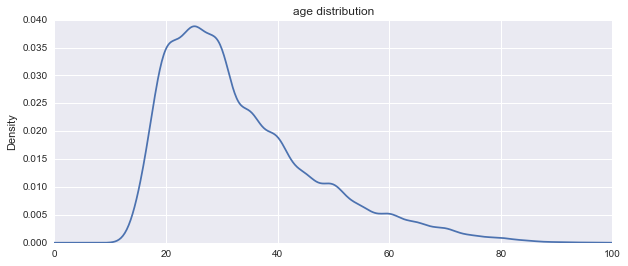

In [159]:

mask = big_df.age < 120
ax = big_df[mask].age.plot(kind='kde', title='age distribution', figsize=(10,4))
ax.set_xlim(0, 100)

In [171]:
big_df.country == 'nigeria'

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
        ...  
2970    False
2971    False
2972    False
2973    False
2974    False
2975    False
2976    False
2977    False
2978    False
2979    False
2980    False
2981    False
2982    False
2983    False
2984    False
2985    False
2986    False
2987    False
2988    False
2989    False
2990    False
2991    False
2992    False
2993    False
2994    False
2995    False
2996    False
2997    False
2998    False
2999    False
Name: country, dtype: bool

In [176]:
import ipywidgets

In [180]:

select_column = ipywidgets.Select(
    options=sorted(list(big_df.columns.tolist())),
    description = "Select a column.")

select_column

ValueError: `dataset` input should have multiple elements.

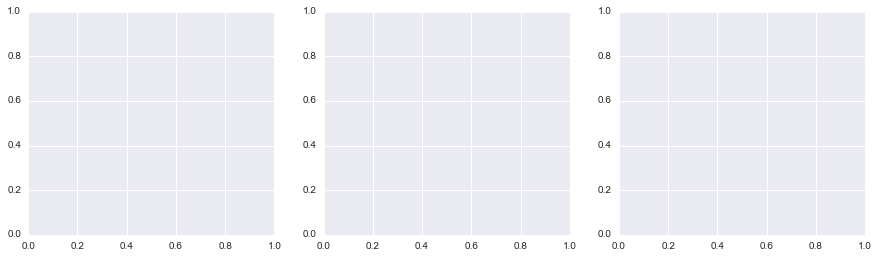

In [181]:
column = select_column.value

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

mask = big_df.age < 120

for country in ['nigeria', 'uganda', 'tanzania']:
    mask = mask & (big_df.country == country)
    if mask.sum() > 0:
        ax = big_df[mask][column].plot(kind='kde', title='age distribution for {}'.format(country))
    ax.set_xlim(0, 100)